# Building Different Strategies For Daily Trading For Cryptocurrencies

In [1]:
import numpy as np
import pandas as pd
import talib as ta# for technical analysis
import random
from pandas_datareader import data
import os
from sklearn.preprocessing import StandardScaler # for preprocesing data
import matplotlib.pyplot as plt # for visualizing data
#from datetime import datetime # for manipulations with time features
import datetime
import time
from sklearn.preprocessing import MinMaxScaler # for preprocesing data
from sklearn import metrics # getting all needed metrcis for the model
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import math
import pytz
import json
from binance.client import Client
import requests 
import seaborn as sns
from datetime import timedelta

#Evaluation
from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier, Pool
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Get Historical Data From Binance

In [2]:
def get_hist_hourly(symbol, start = "2 months ago UTC", end = "now UTC"):
    # Connecting to Binance API
    API_KEY = "LdCZHDrnjgCLIUWyaW2ODGJ1VS8yl86GQtO4LEUDw7HVdzxrbpHHzN0DXoNfIJmD"
    API_SECRET = "DqoItExxTNFZdfK8Sqvo7MHzN2BfXJa1xOGeSUeXol1qrSDJjdUWfe8piTckECUq"
    client = Client(API_KEY, API_SECRET)
    interval = Client.KLINE_INTERVAL_1HOUR
    
    klines = client.get_historical_klines(symbol, interval, start, end)
    df = pd.DataFrame(klines)
    df.columns = ['open_time',
                  'o', 'h', 'l', 'c', 'v',
                  'close_time', 'qav', 'num_trades',
                  'taker_base_vol', 'taker_quote_vol', 'ignore']
    # Time processing
    df.open_time = pd.to_datetime(df.open_time, unit='ms')
    df.close_time = pd.to_datetime(df.close_time, unit='ms')
    df.close_time = df.open_time.copy() + timedelta(hours=1)
    # Cleaning data
    del df['qav']
    del df['taker_base_vol']
    del df['taker_quote_vol']
    del df['ignore']
    del df['open_time']
    del df['num_trades']

    df['o'] = df['o'].astype(float)
    df['h'] = df['h'].astype(float)
    df['l'] = df['l'].astype(float)
    df['c'] = df['c'].astype(float)
    df['v'] = df['v'].astype(float)
    
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df

In [3]:
# Export data
data = get_hist_hourly("ETHUSDT")
data.to_csv(r'data/data_2M_3_16_2020.csv')

In [4]:
# Import data
data = pd.read_csv('data/data_2M_3_16_2020.csv', na_values = ['nan'], index_col = 0)
#data.close_time = pd.to_datetime(data.close_time).apply(lambda x: x.date())
data.head()

,close_time,o,h,l,c,v
0,2020-01-16 20:00:00,163.36,164.02,163.24,163.57,7087.67028
1,2020-01-16 21:00:00,163.56,165.67,163.50,165.56,14076.13853
2,2020-01-16 22:00:00,165.55,165.88,162.31,163.39,23700.39404
3,2020-01-16 23:00:00,163.40,164.38,162.83,164.14,8014.44161
4,2020-01-17 00:00:00,164.11,165.00,163.30,164.21,10432.75359


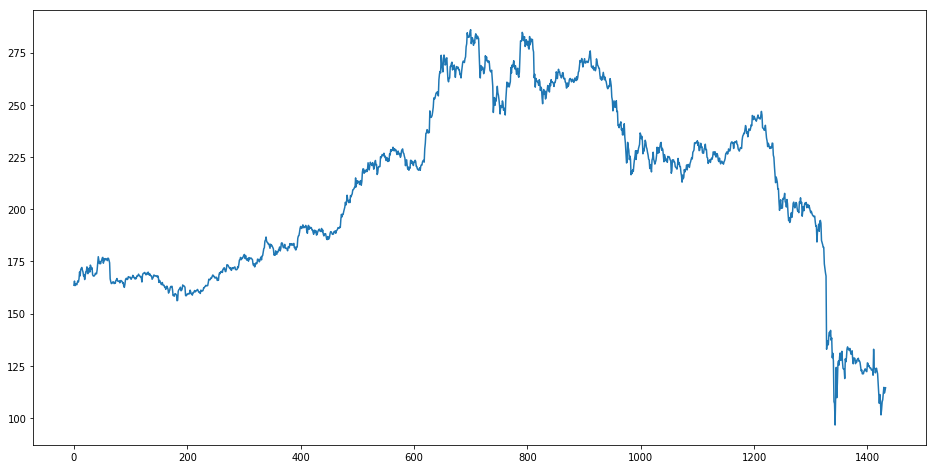

In [5]:
#Let's visualize some data
plt.figure(figsize=(16,8))
plt.plot(data.c)

## Define main functions

In [6]:
def tester(test_ser, take_prof, stop_loss, tplong, tpshort, verb = 1, strategy = '', time_period = 30):
    signal = 0
    call = 'flat'
    order_amount = 10
    num = 0
    long_paid = 0
    long_profit = 0
    short_paid = 0
    short_profit = 0
    order_book = pd.DataFrame(columns = ['time', 'price', 'paid', 'size', 'order', 'type',
                                         'close_time', 'close_price','profit', 'perc', 'TP', 'SL'])
    ti = time.time()
    test_ser.reset_index(drop=True, inplace = True)
    #test_ser = test_ser.loc[-time_period:, :].copy()
    test_ser = test_ser.tail(time_period).copy()
    test_ser.reset_index(drop=True, inplace = True)
    for c in range(test_ser.shape[0]):

        if test_ser[strategy].loc[c] == 1:
            signal = 1
            call = 'long'
            price_d = 1.001
        elif test_ser[strategy].loc[c] == -1:
            signal = -1
            call = 'short'
            price_d = 0.999
        elif test_ser[strategy].loc[c] == 0:
            signal = 0
            call = 'flat'
        else:
            signal = 2
            call = 'flat'
            
        # Create Order
        if call != 'flat':
            price = price_d * test_ser.c[c]
            paid = order_amount
            coins = paid/price
            paid = paid*1.0025
            if call == 'long':
                long_paid += paid
                sl = stop_loss * price
            else:
                short_paid += paid
                sl = (2 - stop_loss) * price
            order_book.loc[num] = [test_ser.close_time[c], price, paid, coins, call, 'open', 
                                   test_ser.close_time[c], price, 0, 0, take_prof, sl]
            num += 1
        
        # Stop Loss, Take Profit, Time Stop
        for index, row in order_book[order_book['type'] == 'open'].iterrows():
            if row['order'] == 'long' and (tplong(signal) or c == test_ser.shape[0] - 1):
                # Close Order
                order_book.loc[index,:], long_profit = take_long_prof(row, 
                                                                      test_ser.c[c], 
                                                                      test_ser.close_time[c], 
                                                                      long_profit)
            
            if row['order'] == 'short' and (tpshort(signal) or c == test_ser.shape[0] - 1):
                # Close Order
                order_book.loc[index,:], short_profit = take_short_prof(row, 
                                                                        test_ser.c[c], 
                                                                        test_ser.close_time[c], 
                                                                        short_profit)
        if (c+1)%200==0 and verb == 1:
            ord_book = order_book.copy(deep = True)
            ord_book.to_csv(r'orders_not.csv')
            print('Perc_long = ' + '{0:.2f}'.format(100*long_profit / (long_paid+0.0001)) + '%' )
            print("Perc_short = " + "{0:.2f}".format(100*short_profit / (short_paid+ 0.0001)) + '%' )
            progress_display(c + 1, len(test_ser.close_time), ti)
            print('-----------------------------------')
    if verb == 1:
        print('Paid for long', long_paid)
        print('Profit from long', long_profit)
        print('Perc_long = ' + '{0:.2f}'.format(100*long_profit / (long_paid+0.0001)) + '%' )
        print('Paid for short', short_paid)
        print('Profit from short', short_profit)
        print("Perc_short = " + "{0:.2f}".format(100*short_profit / (short_paid+0.0001)) + '%' )
    ord_book = order_book.copy(deep = True)
    #for z in range(len(order_book.time)):
    #    ord_book.loc[z,'time'] = ord_book.loc[z,'time'].strftime("%Y-%m-%d %H:%M:%S")
    #    ord_book.loc[z,'close_time'] = ord_book.loc[z,'close_time'].strftime("%Y-%m-%d %H:%M:%S")
    ord_book['perc'] = ord_book['perc'] * 100
        
    return ord_book, [long_paid, long_profit, short_paid, short_profit]

In [7]:
def take_long_prof(row, pr, time, longg_profit):
    row = row.copy()
    row['close_time'] = time
    row.loc['type'] = 'close'
    price = 0.999*pr
    row.loc['profit'] = row.loc['size']*price*0.999 - row.loc['paid']
    row.loc['perc'] = row.loc['size']*price*0.999 / row.loc['paid'] - 1
    longg_profit += row.loc['profit']
    row.loc['close_price'] = price
    return row, longg_profit
    
def take_short_prof(row, pr, time, shortt_profit):
    row = row.copy()
    row['close_time'] = time
    row['type'] = 'close'
    price = 1.001*pr
    row['profit'] = row['paid'] - row['size']*price*0.999
    row['perc'] = row['paid'] / (row['size']*price*0.999) - 1
    shortt_profit += row['profit']
    row['close_price'] = price
    return row, shortt_profit

In [8]:
def plot_orders(orders, test_ser, signal):
    orders.time = pd.to_datetime(orders.time)
    orders.close_time = pd.to_datetime(orders.close_time)
    test_ser.close_time = pd.to_datetime(test_ser.close_time)
    test_ser.set_index('close_time', inplace=True)
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(test_ser['c'])
    color = '-vr'
    if signal == 'long':
        color = '-^g'
    for index, row in orders[orders['order'] == signal].iterrows():
        #print(row)
        x1 = row.loc['time']
        x2 = row.loc['close_time']
        y1 = test_ser.loc[x1, 'c']
        y2 = test_ser.loc[x2, 'c']
        #print(x1, x2, y1, y2)
        ax.plot([x1,x2], [y1, y2], color, linewidth=.5)

In [9]:
def progress_display(a, b, ti):
    percc = 100 * a / b
    print("Progress: " + "{0:.2f}".format(percc) + '%')
    ttt = time.time() - ti
    time_now = chop_microseconds(datetime.timedelta(seconds = ttt))
    print("Time: " + str(time_now))
    time_left = chop_microseconds(datetime.timedelta(seconds = (100 * (ttt / percc)) - ttt))
    print("Left time: " + str(time_left))

In [10]:
def chop_microseconds(delta):
    return delta - datetime.timedelta(microseconds=delta.microseconds)

## 1. Moving Averages

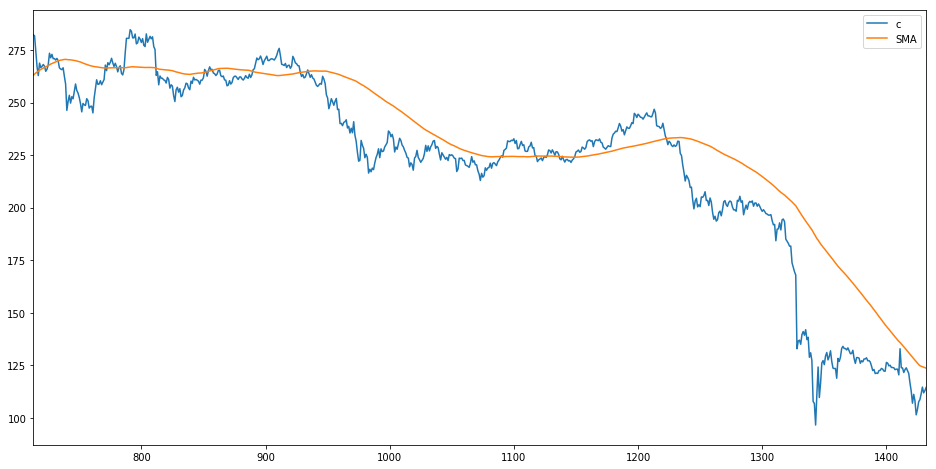

In [32]:
# MA
data['SMA'] = ta.SMA(data.c, timeperiod = 100)
data[['c','SMA']].tail(720).plot(figsize=(16,8))

In [33]:
# Create strategy
#data['SMA_startegy'] = np.where(data['SMA'] < data['c'], 1, -1)
data['SMA_startegy'] = 0
data['SMA_startegy'] = np.where((data['SMA'] > data['c']) & (data['SMA'].shift() < data['c'].shift()), -1, data['SMA_startegy'])
data['SMA_startegy'] = np.where((data['SMA'] < data['c']) & (data['SMA'].shift() > data['c'].shift()), 1, data['SMA_startegy'])
#data['SMA_startegy'] = np.where((data['SMA'] > data['c']), -1, data['SMA_startegy'])
#data['SMA_startegy'] = np.where((data['SMA'] < data['c']), 1, data['SMA_startegy'])

t_period = 720
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'SMA_startegy', 
                         time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)

Perc_long = -1.72%
Perc_short = -1.24%
Progress: 27.78%
Time: 0:00:01
Left time: 0:00:02
-----------------------------------
Perc_long = -1.61%
Perc_short = 0.12%
Progress: 55.56%
Time: 0:00:02
Left time: 0:00:01
-----------------------------------
Perc_long = -1.44%
Perc_short = -0.04%
Progress: 83.33%
Time: 0:00:03
Left time: 0:00:00
-----------------------------------
Paid for long 150.37500000000003
Profit from long -2.1673982353933603
Perc_long = -1.44%
Paid for short 160.40000000000003
Profit from short 5.035586830455877
Perc_short = 3.14%


In [34]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2020-02-15 18:00:00,262.57716,10.025,0.038084,short,close,2020-02-15 19:00:00,269.04878,-0.211219,-2.06345,0,525.15432
1,2020-02-15 19:00:00,269.04878,10.025,0.037168,long,close,2020-02-16 00:00:00,264.61512,-0.199625,-1.99128,0,0.00000
2,2020-02-16 00:00:00,264.61512,10.025,0.037791,short,close,2020-02-16 02:00:00,268.20794,-0.10064,-0.993908,0,529.23024
3,2020-02-16 02:00:00,268.20794,10.025,0.037285,long,close,2020-02-16 11:00:00,266.27346,-0.107054,-1.06787,0,0.00000
4,2020-02-16 11:00:00,266.27346,10.025,0.037555,short,close,2020-02-18 00:00:00,268.11785,-0.0341975,-0.339962,0,532.54692


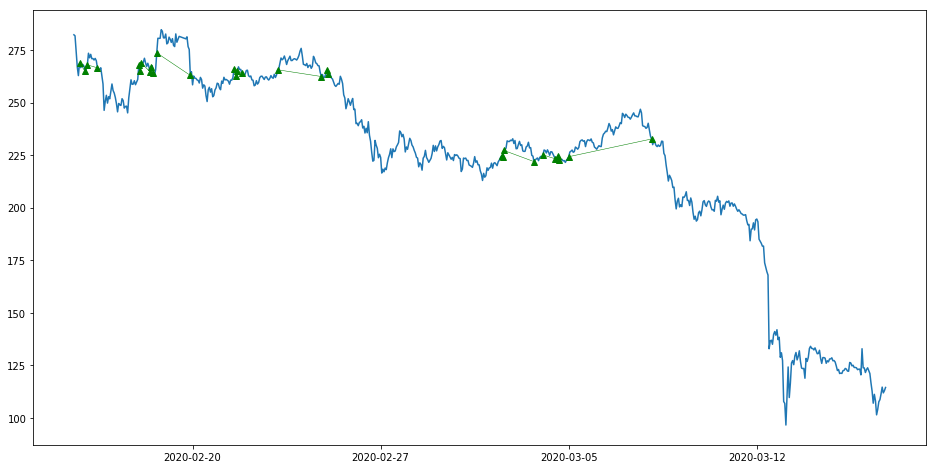

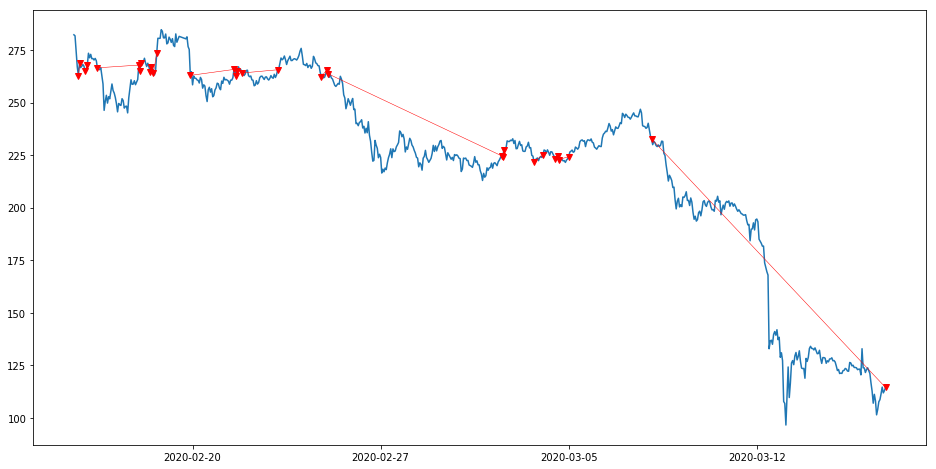

In [35]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

## 2. Bollinger Bands

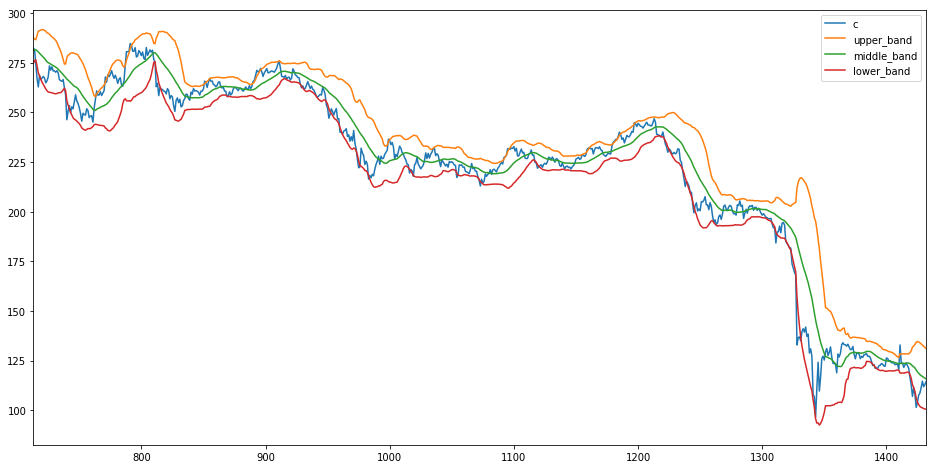

In [24]:
# Bollinger Bands
data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data.c, timeperiod = 24)
# Plot
data[['c','upper_band','middle_band','lower_band']].tail(720).plot(figsize=(16,8))
plt.show()

In [25]:
# Create strategy
data['BB_startegy'] = 0
data['BB_startegy'] = np.where((data['upper_band'] < data['c']) & (data['upper_band'].shift() > data['c'].shift()),
                               -1, 
                               data['BB_startegy'])
data['BB_startegy'] = np.where((data['lower_band'] > data['c']) & (data['lower_band'].shift() < data['c'].shift()),
                               1, 
                               data['BB_startegy'])
bb_dif = (data['upper_band'] - data['middle_band']) * 0.8
data['BB_startegy'] = np.where((data['middle_band']+bb_dif < data['c']) & (data['middle_band'].shift()+bb_dif > data['c'].shift()),
                               2, 
                               data['BB_startegy'])
data['BB_startegy'] = np.where((data['middle_band']-bb_dif > data['c']) & (data['middle_band'].shift()-bb_dif < data['c'].shift()),
                               2, 
                               data['BB_startegy'])
#print(data[['c','upper_band','middle_band','lower_band', 'BB_startegy']])
t_period = 720
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'BB_startegy', 
                         time_period = t_period, 
                         tplong = lambda x: x == 2 or x == -1, 
                         tpshort = lambda x: x == 2 or x == 1)

Perc_long = 0.67%
Perc_short = 0.00%
Progress: 27.78%
Time: 0:00:00
Left time: 0:00:02
-----------------------------------
Perc_long = 0.58%
Perc_short = -0.28%
Progress: 55.56%
Time: 0:00:01
Left time: 0:00:01
-----------------------------------
Perc_long = -0.30%
Perc_short = -1.52%
Progress: 83.33%
Time: 0:00:02
Left time: 0:00:00
-----------------------------------
Paid for long 120.30000000000001
Profit from long -0.6266037826274466
Perc_long = -0.52%
Paid for short 20.049999999999997
Profit from short -0.30384976827241594
Perc_short = -1.52%


In [26]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2020-02-15 20:00:00,266.89663,10.025,0.037468,long,close,2020-02-16 15:00:00,262.24749,-0.209018,-2.08497,0,0.0
1,2020-02-16 16:00:00,259.08883,10.025,0.038597,long,close,2020-02-17 17:00:00,260.58915,0.0228496,0.227927,0,0.0
2,2020-02-16 20:00:00,250.00976,10.025,0.039998,long,close,2020-02-17 17:00:00,260.58915,0.387736,3.86769,0,0.0
3,2020-02-24 19:00:00,262.67241,10.025,0.038070,long,close,2020-02-24 21:00:00,261.49824,-0.0796562,-0.794576,0,0.0
4,2020-02-26 16:00:00,226.57635,10.025,0.044135,long,close,2020-02-26 22:00:00,223.53624,-0.169042,-1.6862,0,0.0


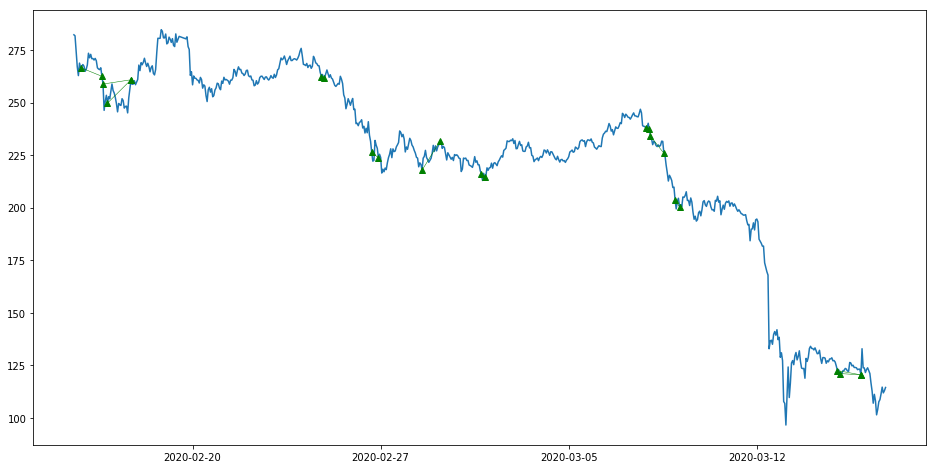

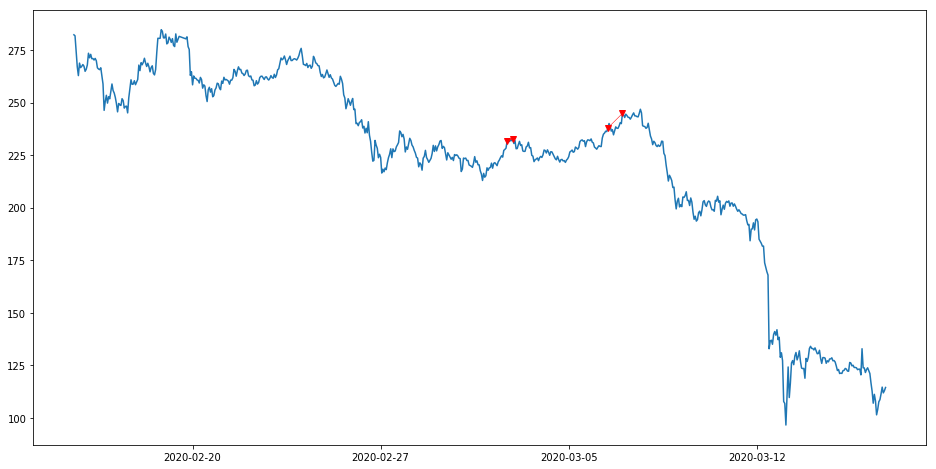

In [27]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

## 3. MACD Strategy

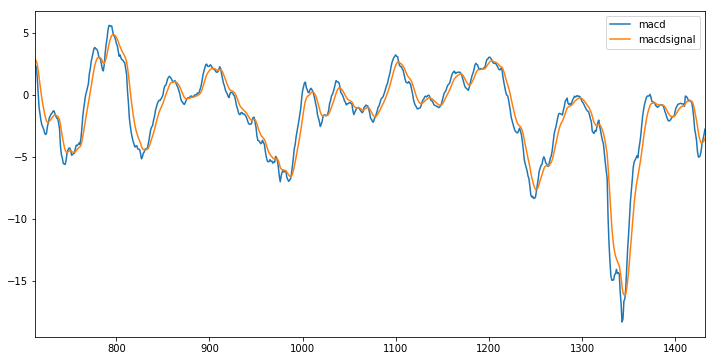

In [19]:
# MACD
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data.c, fastperiod=12, slowperiod=26, signalperiod=9)
data[['macd','macdsignal']].tail(720).plot(figsize=(12,6))